<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [3]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><strong><u>Data Preparation</u></strong></h2>

In [4]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [5]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [7]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [8]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [9]:
custom_f1_scorer_spam = make_scorer(f1_score, greater_is_better=True, pos_label='spam')
custom_f1_scorer_ham = make_scorer(f1_score, greater_is_better=True, pos_label='ham')

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Tests</u></strong></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ...................................clf__alpha=0.001; total time=   0.8s
[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.9s
[CV] END ......................................clf__alpha=10; total time=   0.8s
[CV] END .....................................clf__alpha=0.1; total time=   0.9s
[CV] END ...................................clf__alpha=0.001; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.9s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.8s remaining:    2.8s


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


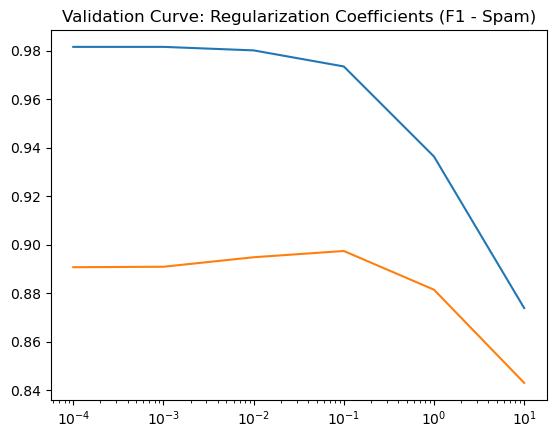

In [39]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_spam,
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Spam)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.9s
[CV] END .......................................clf__alpha=1; total time=   0.9s
[CV] END ..................................clf__alpha=0.0001; total time=   0.9s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.7s remaining:    2.7s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


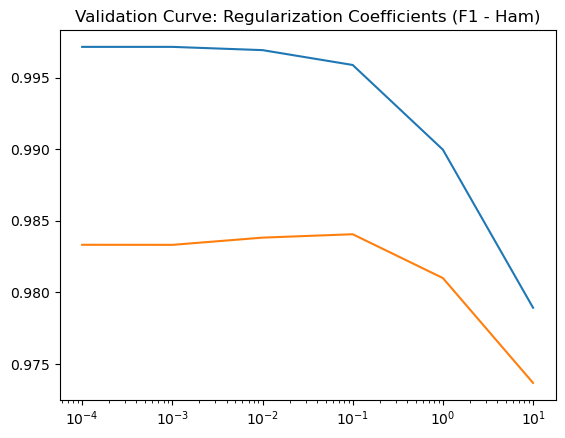

Exception ignored in: <function ResourceTracker.__del__ at 0x106d89bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102191bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106e95bc0>
Traceback (most recent call last

In [20]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_ham,
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Ham)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [16]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 
param_grid = {"clf__alpha": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=custom_f1_scorer_spam, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

def bayesian_cv():
    return nb_model

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................................clf__alpha=0.1; total time=   3.0s
[CV] END .....................................clf__alpha=0.3; total time=   3.1s
[CV] END .....................................clf__alpha=0.1; total time=   3.1s
[CV] END .....................................clf__alpha=0.3; total time=   3.1s
[CV] END .....................................clf__alpha=0.1; total time=   3.2s
[CV] END .....................................clf__alpha=0.3; total time=   3.1s
[CV] END .....................................clf__alpha=0.1; total time=   3.2s
[CV] END .....................................clf__alpha=0.1; total time=   3.1s
[CV] END .....................................clf__alpha=0.3; total time=   0.6s
[CV] END .....................................clf__alpha=0.3; total time=   0.6s
[CV] END .....................................clf__alpha=0.5; total time=   0.6s
[CV] END .....................................clf

<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was the f1 score. F1 score is a good method to access the model's performance on the 'positive' class; spam in this instance; especially for imbalanced dataset or even datasets that have been synthetically balanced like this one. Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on the f1 scores. For the regularization coefficient, I found that the best regularization coefficient will mostly likely be 0.1. Therefore, I used a small range of regularization coefficients that included 0.1, along with SMOTE in a pipeline for the Grid Search cross-validation test. As expected, after running the cross-validation test, I found that the best value for alpha was 0.1.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [41]:
clf_metrics = {'F1 (Spam)': custom_f1_scorer_spam, 'F1 (Ham)': custom_f1_scorer_ham}

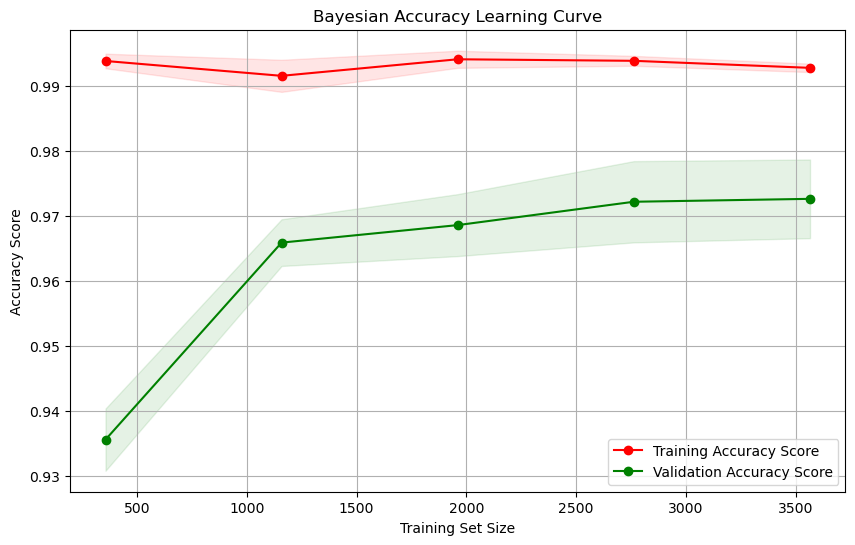

In [42]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy Score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Validation Accuracy Score")

plt.legend(loc="best")
plt.show()

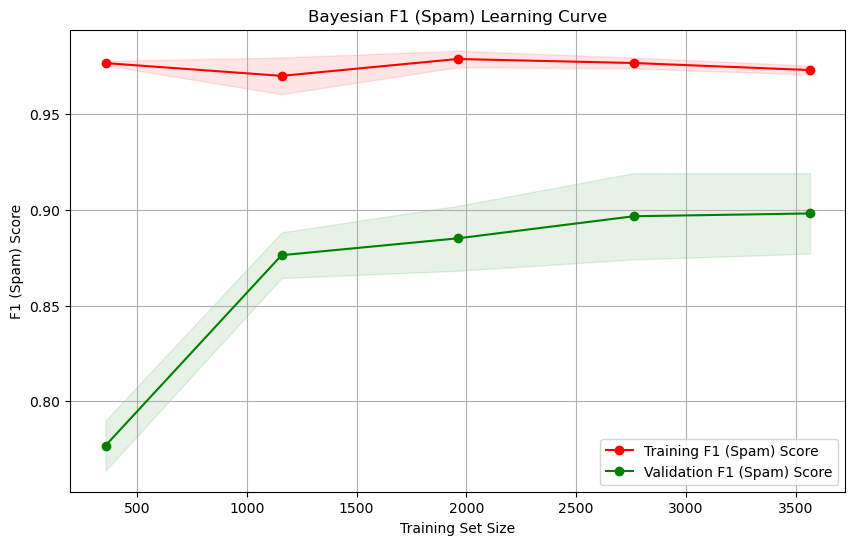

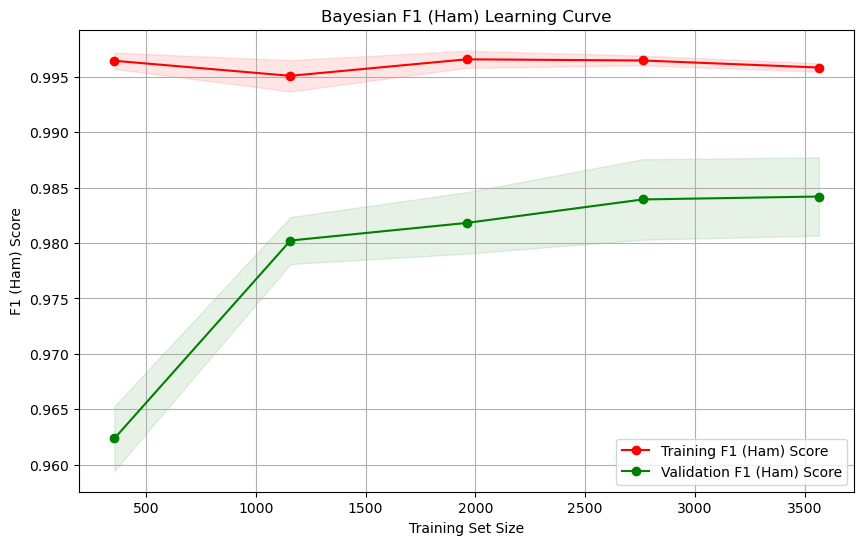

In [44]:
for key, value in clf_metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {key} Score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} Score")

    plt.legend(loc="best")
    plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [57]:
#Cross-Validation Loop
print("Accuracy")
nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("CV Training Scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print("Training Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.96636771 0.98318386 0.96969697 0.97418631 0.96857464]
Training Average and Standard Error: 0.97% ± 0.60% 



In [58]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train, scoring=value, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

F1 (Spam)
CV Training Scores:  [0.87804878 0.93617021 0.88510638 0.90128755 0.88617886]
Training Average and Standard Error:  0.90% ± 2.08% 

F1 (Ham)
CV Training Scores:  [0.98049415 0.99031633 0.98254686 0.98515171 0.98177083]
Training Average and Standard Error:  0.98% ± 0.35% 



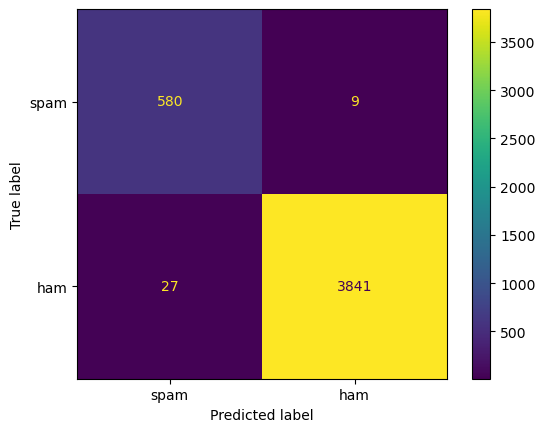

In [17]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(estimator=nb_model, X=X_train, y=y_train, labels=['spam', 'ham'])

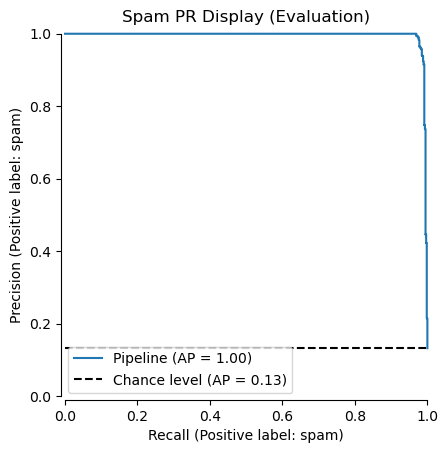

In [21]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label='spam', plot_chance_level=True, despine=True)
disp.ax_.set_title("Spam PR Display (Evaluation)")
plt.show()

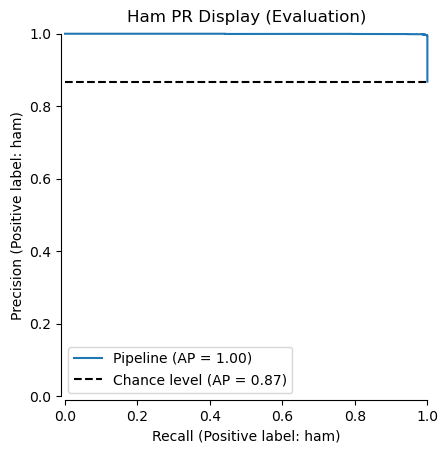

In [22]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label='ham', plot_chance_level=True, despine=True)
disp.ax_.set_title("Ham PR Display (Evaluation)")
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected model, I found positive results for all evaluation methods. The learning curves yielded good results with validation scores trending upwards with increases in the training size indicating that the model's performance will increase if provided more data. This is very crucial since the original dataset was inbalanced in favor of 'ham' messages. Therefore, the 'F1 (Spam)' learning curve shows me that if more 'spam' data points are provided, then the model will be able to learn from them. Also, the 'cross_val_score' function evaluation results were in keeping with the learning curve values which helps to solidify the model's evaluation results. In addition, the Confusion Matrix helps show that the model performed well on the training data with minimal False Negatives and False Positives. Finally, The Precision-Recall plots displays a good curve that moves to the top-right corner of the plot indicating a good classifier model. As a result, I will move forward with this model to the 'Model Testing' section.

<h2><strong><u>Model Testing</u></strong></h2>

<h3><strong><u>Performance Metrics</u></strong></h3>

In [18]:
test_predictions = nb_model.predict(X_test)

In [61]:
#Cross-Validation Loop
print("Accuracy")
nb_test_values = cross_val_score(nb_model, X_test, y_test, scoring='accuracy', cv=5)
print("CV test Scores: ", nb_test_values)
np_nb_test_values = np.array(nb_test_values)
average = np.mean(np_nb_test_values)
stDev = np.std(np_nb_test_values)
print("Test Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV test Scores:  [0.94170404 0.95067265 0.92376682 0.95964126 0.95067265]
Test Average and Standard Error: 0.95% ± 1.22% 



In [62]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_testing_values = cross_val_score(nb_model, X_test, y=y_test, scoring=value, cv=5)
    print("CV Test Scores: ", nb_testing_values)
    np_nb_testing_values = np.array(nb_testing_values)
    average = np.mean(np_nb_testing_values)
    stDev = np.std(np_nb_testing_values)
    print(f"Test Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

F1 (Spam)
CV Test Scores:  [0.78688525 0.8358209  0.77922078 0.85714286 0.82539683]
Test Average and Standard Error:  0.82% ± 2.96% 

F1 (Ham)
CV Test Scores:  [0.96623377 0.97097625 0.95392954 0.97650131 0.97127937]
Test Average and Standard Error:  0.97% ± 0.77% 



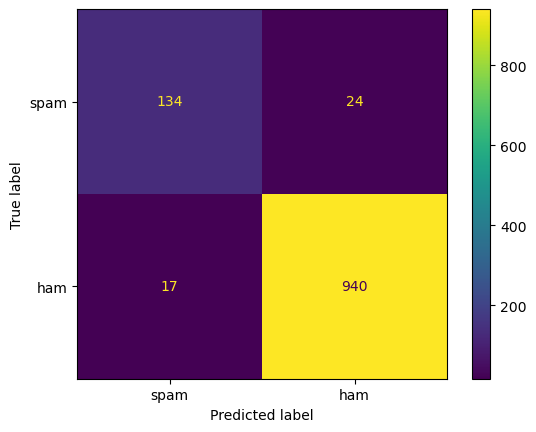

In [19]:
# #Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions, labels=['spam', 'ham'])

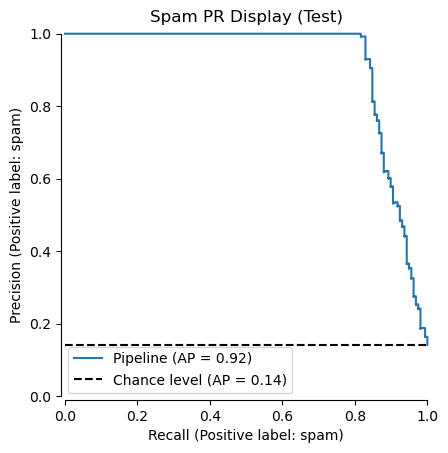

In [24]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_test, y_test, pos_label="spam", plot_chance_level=True, despine=True)
disp.ax_.set_title("Spam PR Display (Test)")
plt.show()

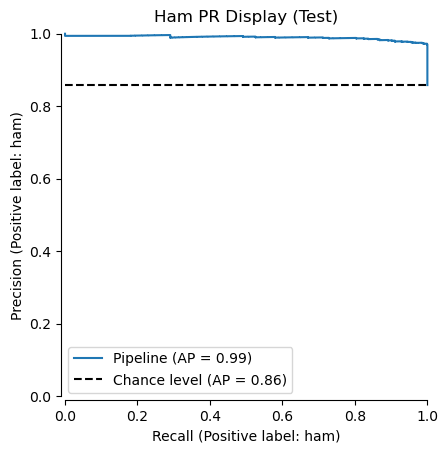

In [26]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_test, y_test, pos_label="ham", plot_chance_level=True, despine=True)
disp.ax_.set_title("Ham PR Display (Test)")
plt.show()

<h4><strong><u>Findings From 'Model Testing' Phase</u></strong></h4>
In the testing phase of my selected model, I found that the testing results were good and in keeping with my results from the 'Model Evaluation' section. The 'cross_val_score' function evaluation results, Confusion Matrix display, and PR displays were all in keeping with the results from the 'Model Evaluation' section. 

<h2><strong><u>Conclusion</u></strong></h2>
In conclusion, I believe that this model will perform well as spam classifier. The 'F1 (Spam)' testing results are something to be aware of but as I previously stated, if given more 'spam' data points, then the model will be able to learn from those data points and produce more accurate 'spam' classification results.